In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset ,random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from scipy.linalg import sqrtm

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root="/kaggle/input/celeba-dataset", transform=transform)

subset_size = int(0.1 * len(full_dataset))

subset_dataset, _ = torch.utils.data.random_split(full_dataset, [subset_size, len(full_dataset) - subset_size])

train_size = int(0.8 * len(subset_dataset))
val_size = int(0.1 * len(subset_dataset))
test_size = len(subset_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def calculate_fid(images1, images2, device):
    images1 = images1.detach().cpu().numpy().transpose(0, 2, 3, 1).reshape(-1, channels)
    images2 = images2.detach().cpu().numpy().transpose(0, 2, 3, 1).reshape(-1, channels)

    mean1, cov1 = np.mean(images1, axis=0), np.cov(images1, rowvar=False)
    mean2, cov2 = np.mean(images2, axis=0), np.cov(images2, rowvar=False)

    mean_diff = mean1 - mean2
    mean_diff_squared = np.dot(mean_diff, mean_diff)

    cov_product = sqrtm(np.dot(cov1, cov2))

    if np.iscomplexobj(cov_product):
        cov_product = cov_product.real

    fid_score = mean_diff_squared + np.trace(cov1 + cov2 - 2 * cov_product)
    return fid_score

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [ ]:

latent_dim = 100
lr = 0.0002
batch_size = 128
image_size = 64
channels = 3
num_epochs = 10
sample_interval = 400

In [ ]:

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


In [ ]:

def min_max_gan_loss(generator, discriminator, real_imgs, device):

    z = torch.randn(real_imgs.size(0), generator.latent_dim, device=device)
    gen_imgs = generator(z)
    g_loss = F.binary_cross_entropy(discriminator(gen_imgs), torch.ones_like(discriminator(gen_imgs)))

    real_loss = F.binary_cross_entropy(discriminator(real_imgs), torch.ones_like(discriminator(real_imgs)))
    fake_loss = F.binary_cross_entropy(discriminator(gen_imgs.detach()), torch.zeros_like(discriminator(gen_imgs)))
    d_loss = real_loss + fake_loss

    return g_loss, d_loss



In [ ]:

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:

for epoch in range(num_epochs):
    g_losses_mm = []
    d_losses_mm = []

    for i, (imgs, _) in enumerate(train_loader):

        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        real_imgs = imgs.to(device)

        optimizer_G.zero_grad()

        g_loss_mm, _ = min_max_gan_loss(generator, discriminator, real_imgs, device)
        g_losses_mm.append(g_loss_mm.item())

        g_loss_mm.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        _, d_loss_mm = min_max_gan_loss(generator, discriminator, real_imgs, device)
        d_losses_mm.append(d_loss_mm.item())

        d_loss_mm.backward()
        optimizer_D.step()

    print(
        f"Epoch [{epoch}/{num_epochs}], "
        f"Generator Loss (Min-Max GAN): {np.mean(g_losses_mm):.4f}, "
        f"Discriminator Loss (Min-Max GAN): {np.mean(d_losses_mm):.4f}"
    )


Epoch [0/10], Generator Loss (Min-Max GAN): 6.3173, Discriminator Loss (Min-Max GAN): 0.4824
Epoch [1/10], Generator Loss (Min-Max GAN): 4.8144, Discriminator Loss (Min-Max GAN): 0.6390
Epoch [2/10], Generator Loss (Min-Max GAN): 3.6253, Discriminator Loss (Min-Max GAN): 0.7468
Epoch [3/10], Generator Loss (Min-Max GAN): 4.0399, Discriminator Loss (Min-Max GAN): 0.6638
Epoch [4/10], Generator Loss (Min-Max GAN): 3.5210, Discriminator Loss (Min-Max GAN): 0.7312
Epoch [5/10], Generator Loss (Min-Max GAN): 3.3330, Discriminator Loss (Min-Max GAN): 0.7713
Epoch [6/10], Generator Loss (Min-Max GAN): 3.4120, Discriminator Loss (Min-Max GAN): 0.7548
Epoch [7/10], Generator Loss (Min-Max GAN): 3.5879, Discriminator Loss (Min-Max GAN): 0.6680
Epoch [8/10], Generator Loss (Min-Max GAN): 3.7982, Discriminator Loss (Min-Max GAN): 0.6576
Epoch [9/10], Generator Loss (Min-Max GAN): 3.8031, Discriminator Loss (Min-Max GAN): 0.6474


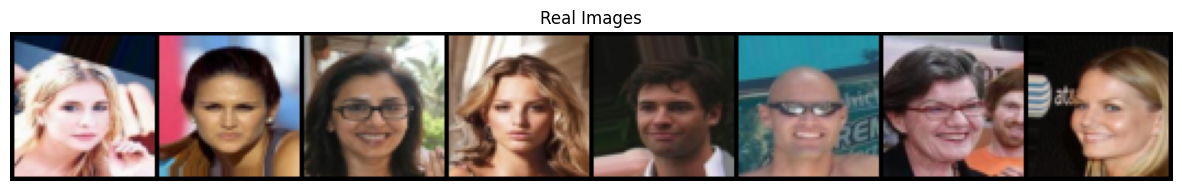

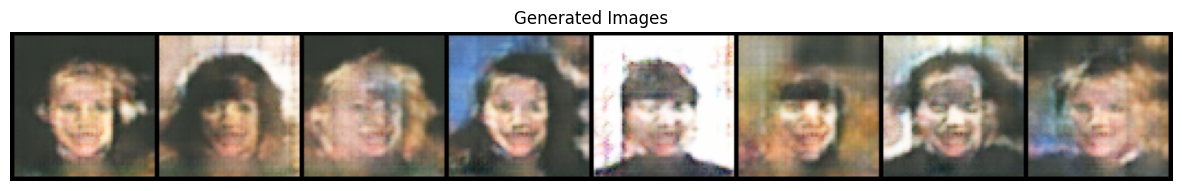

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_images(images, title, nrow=8):
    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:8], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

def generate_and_plot(generator, num_images=8):
    z = torch.randn(num_images, latent_dim, device=device)
    gen_imgs = generator(z)
    plot_images(gen_imgs, title="Generated Images")

real_batch, _ = next(iter(train_loader))
plot_images(real_batch, title="Real Images")

generate_and_plot(generator)


In [ ]:
generator_ls = Generator().to(device)
discriminator_ls = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator_ls.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator_ls.parameters(), lr=0.0002, betas=(0.5, 0.999))

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


In [ ]:
def least_squares_gan_loss(generator, discriminator, real_imgs, device):

    z = torch.randn(real_imgs.size(0), generator.latent_dim, device=device)
    gen_imgs = generator(z)
    g_loss = torch.mean((discriminator(gen_imgs) - 1) ** 2)

    real_loss = torch.mean((discriminator(real_imgs) - 1) ** 2)
    fake_loss = torch.mean(discriminator(gen_imgs) ** 2)
    d_loss = real_loss + fake_loss

    return g_loss, d_loss

Epoch [0/10], Generator Loss (LS GAN): 0.9344, Discriminator Loss (LS GAN): 0.0676
Epoch [1/10], Generator Loss (LS GAN): 0.9336, Discriminator Loss (LS GAN): 0.0677
Epoch [2/10], Generator Loss (LS GAN): 0.9332, Discriminator Loss (LS GAN): 0.0677
Epoch [3/10], Generator Loss (LS GAN): 0.9352, Discriminator Loss (LS GAN): 0.0675
Epoch [4/10], Generator Loss (LS GAN): 0.9345, Discriminator Loss (LS GAN): 0.0678
Epoch [5/10], Generator Loss (LS GAN): 0.9335, Discriminator Loss (LS GAN): 0.0674
Epoch [6/10], Generator Loss (LS GAN): 0.9351, Discriminator Loss (LS GAN): 0.0676
Epoch [7/10], Generator Loss (LS GAN): 0.9348, Discriminator Loss (LS GAN): 0.0675
Epoch [8/10], Generator Loss (LS GAN): 0.9340, Discriminator Loss (LS GAN): 0.0669
Epoch [9/10], Generator Loss (LS GAN): 0.9351, Discriminator Loss (LS GAN): 0.0671


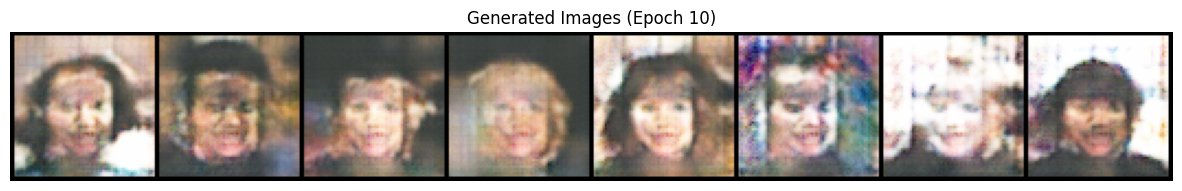

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    g_losses_ls = []  # LSGAN losses
    d_losses_ls = []  # LSGAN losses

    for i, (imgs, _) in enumerate(train_loader):

        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        real_imgs = imgs.to(device)

        optimizer_G.zero_grad()

        g_loss_ls, _ = least_squares_gan_loss(generator, discriminator, real_imgs, device)
        g_losses_ls.append(g_loss_ls.item())

        g_loss_ls.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        _, d_loss_ls = least_squares_gan_loss(generator, discriminator, real_imgs, device)
        d_losses_ls.append(d_loss_ls.item())

        d_loss_ls.backward()
        optimizer_D.step()

    print(
        f"Epoch [{epoch}/{num_epochs}], "
        f"Generator Loss (LS GAN): {np.mean(g_losses_ls):.4f}, "
        f"Discriminator Loss (LS GAN): {np.mean(d_losses_ls):.4f}"
    )

    if epoch ==9:
        with torch.no_grad():
            fixed_noise = torch.randn(8, latent_dim, device=device)
            gen_imgs = generator(fixed_noise).cpu().detach()

        plt.figure(figsize=(15, 15))
        plt.axis("off")
        plt.title(f"Generated Images (Epoch {epoch+1})")
        plt.imshow(np.transpose(vutils.make_grid(gen_imgs, padding=2, normalize=True), (1, 2, 0)))
        plt.show()

In [ ]:
def calculate_fid(images1, images2, device):
    images1 = images1.detach().cpu().numpy().transpose(0, 2, 3, 1).reshape(-1, channels)
    images2 = images2.detach().cpu().numpy().transpose(0, 2, 3, 1).reshape(-1, channels)

    mean1, cov1 = np.mean(images1, axis=0), np.cov(images1, rowvar=False)
    mean2, cov2 = np.mean(images2, axis=0), np.cov(images2, rowvar=False)

    mean_diff = mean1 - mean2
    mean_diff_squared = np.dot(mean_diff, mean_diff)

    cov_product = sqrtm(np.dot(cov1, cov2))
    if np.iscomplexobj(cov_product):
        cov_product = cov_product.real

    fid_score = mean_diff_squared + np.trace(cov1 + cov2 - 2 * cov_product)
    return fid_score

def compare_gan_performance(generator_mm, generator_ls, num_images=800):
    real_images, _ = next(iter(train_loader))
    real_images = real_images.to(device)[:num_images]

    # Generate images from both generators
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, device=device)
        generated_mm_images = generator_mm(z)
        generated_ls_images = generator_ls(z)

    fid_score_mm = calculate_fid(real_images, generated_mm_images, device)
    fid_score_ls = calculate_fid(real_images, generated_ls_images, device)

    print("FID Score for Min-Max GAN:", fid_score_mm)
    print("FID Score for LSGAN:", fid_score_ls)


In [ ]:

compare_gan_performance(generator, generator_ls, num_images=800)


FID Score for Min-Max GAN: 3.389607338493694
FID Score for LSGAN: 1.0227630786601885


In [ ]:
def plot_losses(losses1, losses2, title1, title2):
    plt.figure(figsize=(10, 5))
    epochs = range(len(losses1))
    plt.plot(epochs, losses1, label=title1)
    plt.plot(epochs, losses2, label=title2)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Losses")
    plt.legend()
    plt.show()

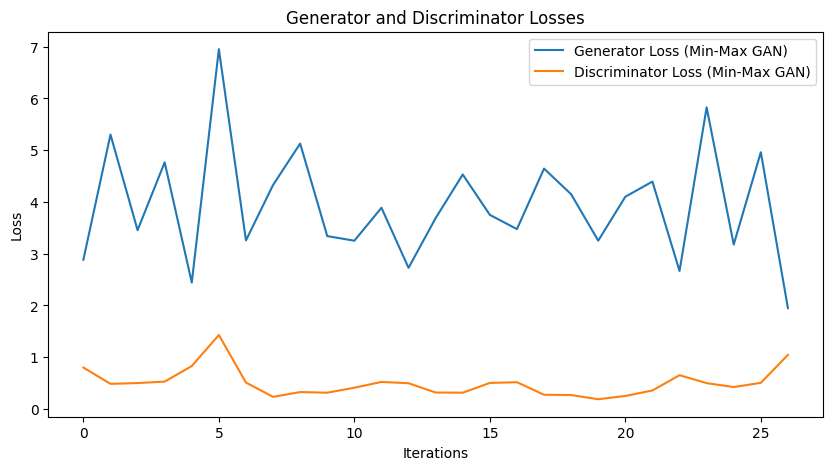

In [ ]:
plot_losses(g_losses_mm, d_losses_mm, "Generator Loss (Min-Max GAN)", "Discriminator Loss (Min-Max GAN)")

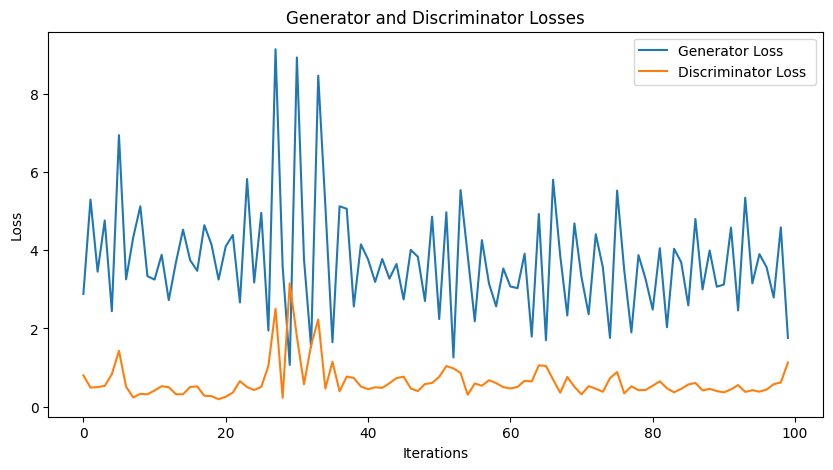

In [ ]:
plot_losses(g_losses_mm, d_losses_mm, "Generator Loss ", "Discriminator Loss ")